In [299]:
# ---- Initial step Data Loading ----
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

# Read the King County Housing dataset
housing_data = pd.read_csv("../data/kc_house_data.csv")

print("Dataset shape:", housing_data.shape)
housing_data.head()

# Confirm there are no duplicate rows - in dataset
duplicates = housing_data.duplicated().sum()
print(f"Duplicate rows: {duplicates}")


Dataset shape: (21613, 21)
Duplicate rows: 0


In [300]:
#step 3- check for missing valuues or duplicate
print("Missing values:\n", housing_data.isna().sum())
print("\nDuplicate rows:", housing_data.duplicated().sum())

Missing values:
 id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Duplicate rows: 0


In [301]:
# --- Next section is - data parsing and basic temporal features checking ---

print("Columns available:", housing_data.columns.tolist())

#Convert the raw date text into a proper datetime object
housing_data["date"] = pd.to_datetime(housing_data["date"], errors="coerce")

#Extract sale year and sale month
housing_data["sale_year"] = housing_data["date"].dt.year
housing_data["sale_month"] = housing_data["date"].dt.month

print(housing_data[["date", "sale_year", "sale_month"]].head())

# Removing identifier and raw date (not meaningful for modeling)
cols_to_remove = ["id", "date"]
housing_data.drop(columns=cols_to_remove, inplace=True)

# Create 'yr_since_renovated' feature  
# NaN for homes that were never renovated so newly built homes are not confused with renovated ones
housing_data["yr_since_renovated"] = np.where(
    housing_data["yr_renovated"] > 0,
    housing_data["sale_year"] - housing_data["yr_renovated"],
    np.nan
)


print("\nAfter dropping ID and raw date:")
print(housing_data.info())

Columns available: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
        date  sale_year  sale_month
0 2014-10-13       2014          10
1 2014-12-09       2014          12
2 2015-02-25       2015           2
3 2014-12-09       2014          12
4 2015-02-18       2015           2

After dropping ID and raw date:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               21613 non-null  float64
 1   bedrooms            21613 non-null  int64  
 2   bathrooms           21613 non-null  float64
 3   sqft_living         21613 non-null  int64  
 4   sqft_lot            21613 non-null  int64  
 5   floors              21613 non

In [302]:
print("Row count:", len(housing_data))



Row count: 21613


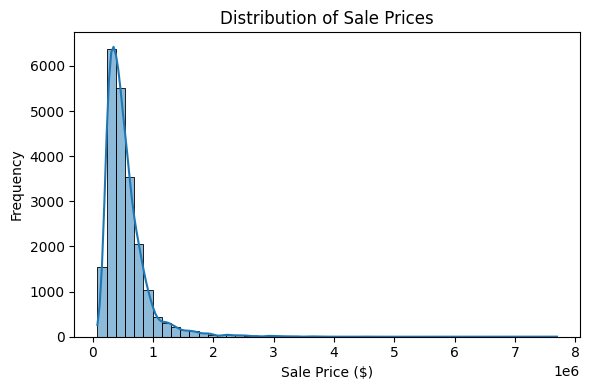

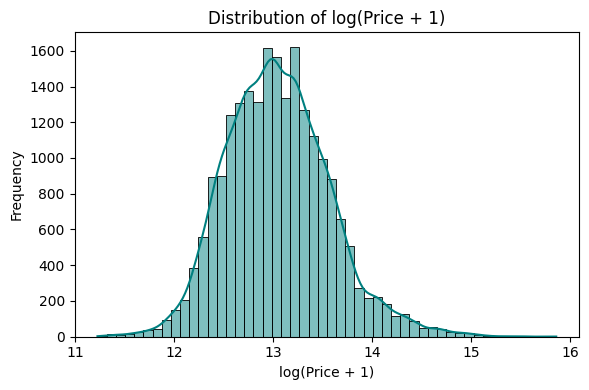


Dataset check after adding log_price:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               21613 non-null  float64
 1   bedrooms            21613 non-null  int64  
 2   bathrooms           21613 non-null  float64
 3   sqft_living         21613 non-null  int64  
 4   sqft_lot            21613 non-null  int64  
 5   floors              21613 non-null  float64
 6   waterfront          21613 non-null  int64  
 7   view                21613 non-null  int64  
 8   condition           21613 non-null  int64  
 9   grade               21613 non-null  int64  
 10  sqft_above          21613 non-null  int64  
 11  sqft_basement       21613 non-null  int64  
 12  yr_built            21613 non-null  int64  
 13  yr_renovated        21613 non-null  int64  
 14  zipcode             21613 non-null  int64  
 15  lat           

In [303]:
# --distribution of sale prices and log trnaformation--

# a) - raw sale price distribution
plt.figure(figsize=(6,4))
sns.histplot(housing_data["price"], bins=50, kde=True)
plt.title("Distribution of Sale Prices")
plt.xlabel("Sale Price ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# b)Create a log-transformed target to handle strong right-skew
housing_data["log_price"] = np.log1p(housing_data["price"])


plt.figure(figsize=(6,4))
sns.histplot(housing_data["log_price"], bins=50, kde=True, color="teal")
plt.title("Distribution of log(Price + 1)")
plt.xlabel("log(Price + 1)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# check dataset again
print("\nDataset check after adding log_price:")
housing_data.info()

In [304]:

# ---- Correlation Analysis with Raw Price ----

# Calculate correlations of numerical features with the original price
price_correlations = (
    housing_data.corr(numeric_only=True)["price"]
    .sort_values(ascending=False)
)

print("\nCorrelation of features with raw price:")
print(price_correlations)



Correlation of features with raw price:
price                 1.000000
log_price             0.891654
sqft_living           0.702035
grade                 0.667434
sqft_above            0.605567
sqft_living15         0.585379
bathrooms             0.525138
view                  0.397293
sqft_basement         0.323816
bedrooms              0.308350
lat                   0.307003
waterfront            0.266369
floors                0.256794
yr_renovated          0.126434
sqft_lot              0.089661
sqft_lot15            0.082447
yr_built              0.054012
condition             0.036362
long                  0.021626
sale_year             0.003576
sale_month           -0.010081
zipcode              -0.053203
yr_since_renovated   -0.128153
Name: price, dtype: float64


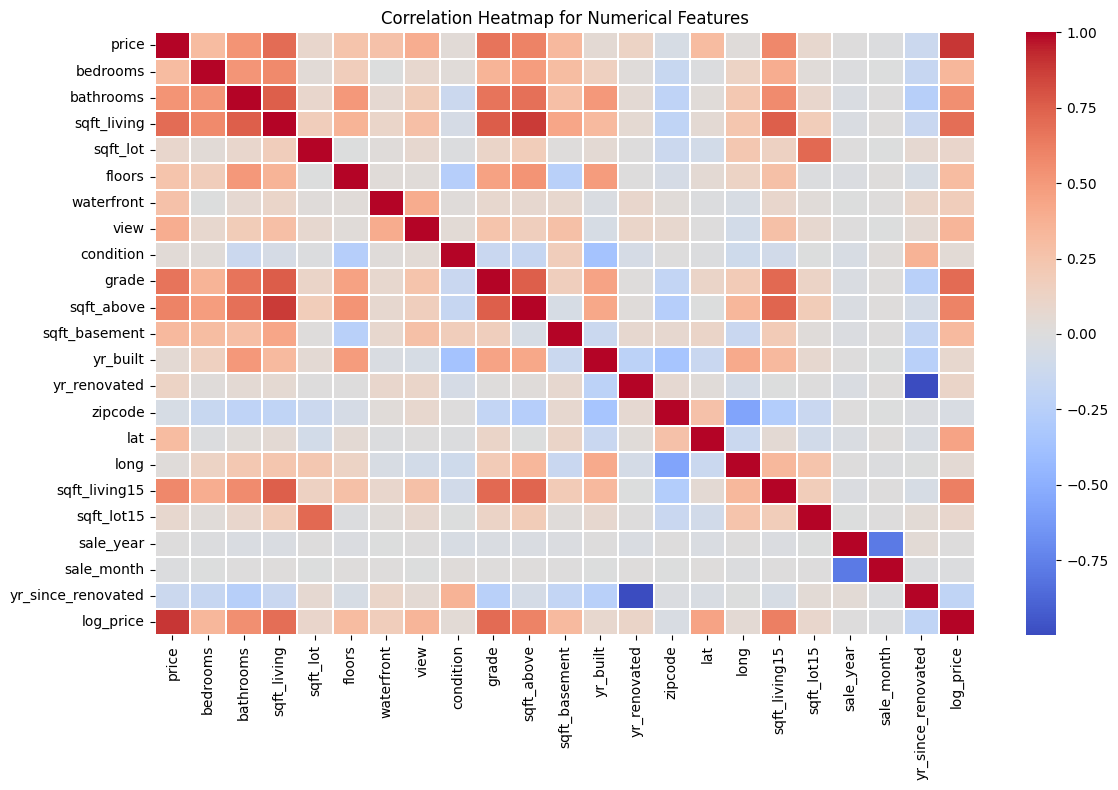


Correlation matrix calculated for numerical columns.


In [305]:
# ----- visualizing feature correlations-

corr_matrix = housing_data.corr(numeric_only=True)

plt.figure(figsize=(12,8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    linewidths=0.3,
    annot=False
)
plt.title("Correlation Heatmap for Numerical Features")
plt.tight_layout()
plt.show()

print("\nCorrelation matrix calculated for numerical columns.")


In [306]:
# ---- Ranking Features by Correlation with Sale Price ----

# Sort correlations with raw price (ascending)
price_corr_sorted = corr_matrix["price"].sort_values(ascending=True)

print("Features ranked by correlation with raw price:\n")
print(price_corr_sorted)

Features ranked by correlation with raw price:

yr_since_renovated   -0.128153
zipcode              -0.053203
sale_month           -0.010081
sale_year             0.003576
long                  0.021626
condition             0.036362
yr_built              0.054012
sqft_lot15            0.082447
sqft_lot              0.089661
yr_renovated          0.126434
floors                0.256794
waterfront            0.266369
lat                   0.307003
bedrooms              0.308350
sqft_basement         0.323816
view                  0.397293
bathrooms             0.525138
sqft_living15         0.585379
sqft_above            0.605567
grade                 0.667434
sqft_living           0.702035
log_price             0.891654
price                 1.000000
Name: price, dtype: float64


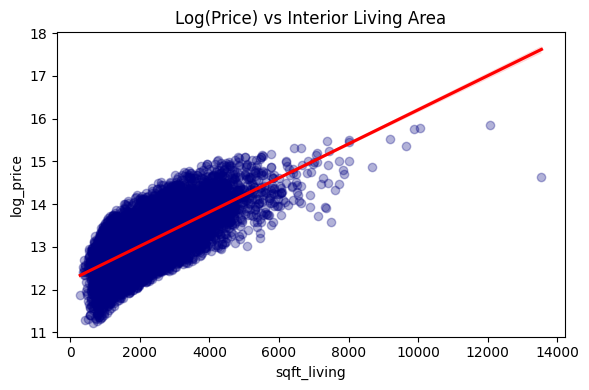

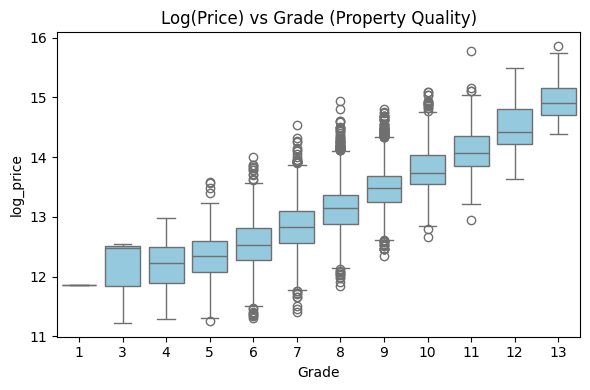

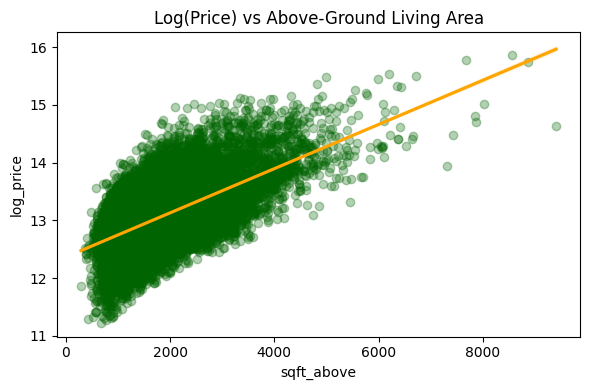

In [307]:
# ----- exploring relationships with high impact predictors -----

# Tier A features : sqft_living, grade, sqft_Above 


#pairwise relationships
# 1) sqft_living vs log_price
plt.figure(figsize=(6,4))
sns.regplot(
    data=housing_data,
    x="sqft_living",
    y="log_price",
    scatter_kws={"alpha":0.3, "color":"navy"},
    line_kws={"color":"red"}
)
plt.title("Log(Price) vs Interior Living Area")
plt.xlabel("sqft_living")
plt.ylabel("log_price")
plt.tight_layout()
plt.show()

# 2) grade (ordinal) vs log_price
plt.figure(figsize=(6,4))
sns.boxplot(data=housing_data, x="grade", y="log_price", color="skyblue")
plt.title("Log(Price) vs Grade (Property Quality)")
plt.xlabel("Grade")
plt.ylabel("log_price")
plt.tight_layout()
plt.show()

# 3) sqft_above vs log_price
plt.figure(figsize=(6,4))
sns.regplot(
    data=housing_data,
    x="sqft_above",
    y="log_price",
    scatter_kws={"alpha":0.3, "color":"darkgreen"},
    line_kws={"color":"orange"}
)
plt.title("Log(Price) vs Above-Ground Living Area")
plt.xlabel("sqft_above")
plt.ylabel("log_price")
plt.tight_layout()
plt.show()

# tier 1 features interpretation:
# - sqft_living and sqft_Above both show strong positive relationships with price , but its non -linear pattern whose effect diminishes for large homes.
# - grade shows step wise increase in price as grade improves. 
# - sqft_above pattern matches to sqft_living but with more spread. Above-ground living area contributes strongly to price, but its impact tapers at high values



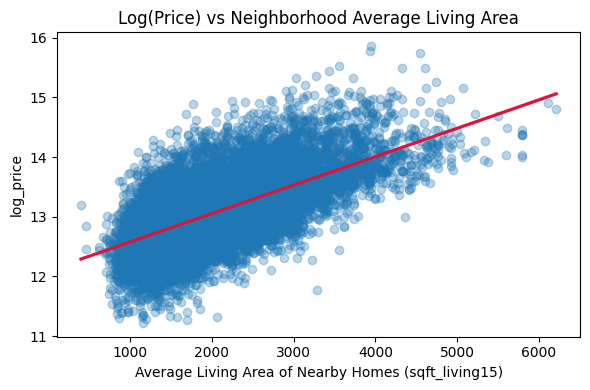

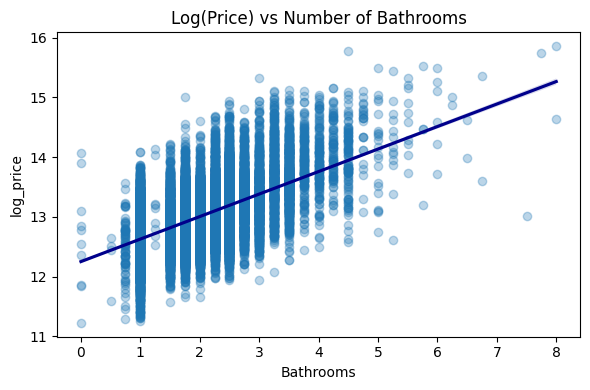

In [308]:
# ---- Tier 2 features exploring : Neighborhood Size + Bathrooms ----

# 1) Neighborhood living-area average vs price
plt.figure(figsize=(6,4))
sns.regplot(
    data=housing_data,
    x="sqft_living15",
    y="log_price",
    scatter_kws={"alpha":0.3},
    line_kws={"color": "crimson"}
)
plt.title("Log(Price) vs Neighborhood Average Living Area")
plt.xlabel("Average Living Area of Nearby Homes (sqft_living15)")
plt.ylabel("log_price")
plt.tight_layout()
plt.show()

# 2) Number of bathrooms vs price
plt.figure(figsize=(6,4))
sns.regplot(
    data=housing_data,
    x="bathrooms",
    y="log_price",
    scatter_kws={"alpha":0.3},
    line_kws={"color": "darkblue"}
)
plt.title("Log(Price) vs Number of Bathrooms")
plt.xlabel("Bathrooms")
plt.ylabel("log_price")
plt.tight_layout()
plt.show()

# interpreatton for these :
# neighbrohoods with larger neighbour homes show higher prices; the trend is almost linear , but slows down after 4500-5000 sqft.
# bathrooms - price increases with bathroom count upto 4-4.5 baths, after which the curve flattens as extra bathrooms add less-marginal value.


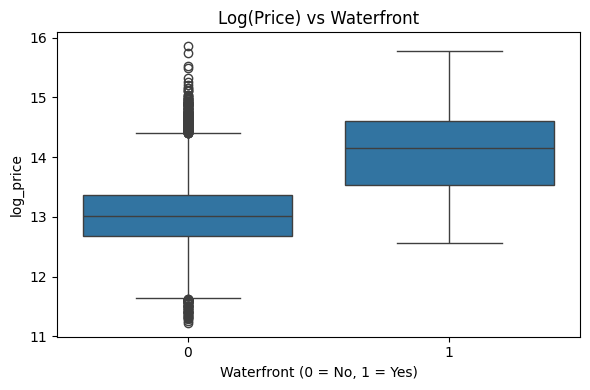

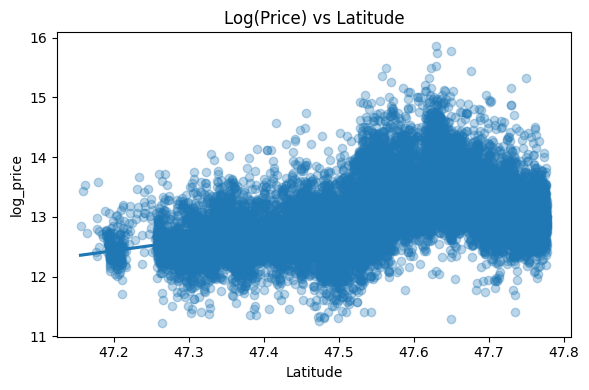

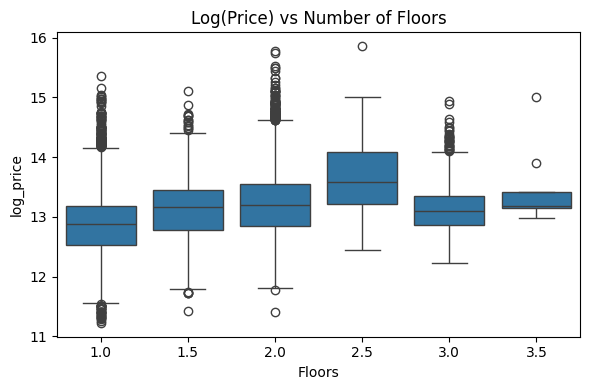

In [309]:
#tier 3...weak positive relationships ....

# 1) Waterfront vs log_price 
plt.figure(figsize=(6,4))
sns.boxplot(data=housing_data, x="waterfront", y="log_price")
plt.title("Log(Price) vs Waterfront")
plt.xlabel("Waterfront (0 = No, 1 = Yes)")
plt.ylabel("log_price")
plt.tight_layout()
plt.show()

# 2) Latitude vs price
plt.figure(figsize=(6,4))
sns.regplot(
    data=housing_data,
    x="lat",
    y="log_price",
    scatter_kws={"alpha":0.3}
)
plt.title("Log(Price) vs Latitude")
plt.xlabel("Latitude")
plt.ylabel("log_price")
plt.tight_layout()
plt.show()

# 3) Number of floors vs price
plt.figure(figsize=(6,4))
sns.boxplot(data=housing_data, x="floors", y="log_price")
plt.title("Log(Price) vs Number of Floors")
plt.xlabel("Floors")
plt.ylabel("log_price")
plt.tight_layout()
plt.show()

#notes:
# waterfront: waterfront homes have visibly high prices, though the effect appears weak since these proeprties are rare. 
# latitude : price increases slightly with latitude in northeern zones, but scatter is broad. 
# no of floors : price increases modestly from 1 to 2 floors, peaking around 2-2.5 floors and later it flattens

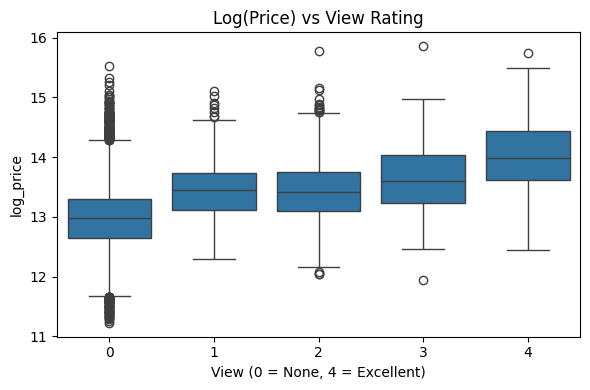

In [310]:
#tier 3...continued... 

plt.figure(figsize=(6,4))
sns.boxplot(data=housing_data, x="view", y="log_price")
plt.title("Log(Price) vs View Rating")
plt.xlabel("View (0 = None, 4 = Excellent)")
plt.ylabel("log_price")
plt.tight_layout()
plt.show()

#view rating : the relationship is montonic positive. As view quality increases, the median and overall price shift upwards. The increase is non-linear - 
# there is clear upward shift for the top view category.

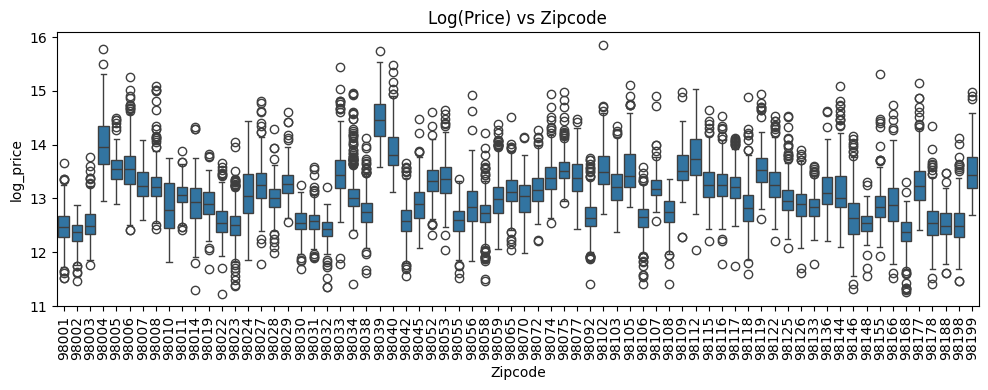

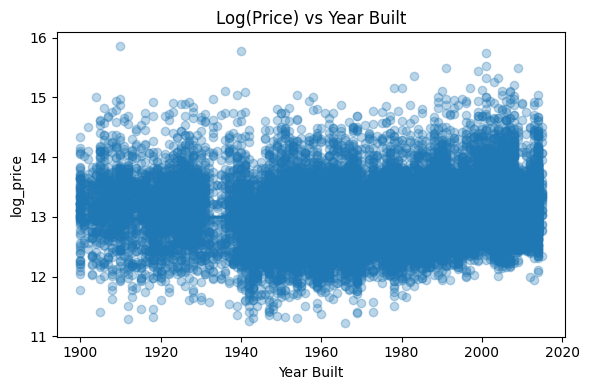

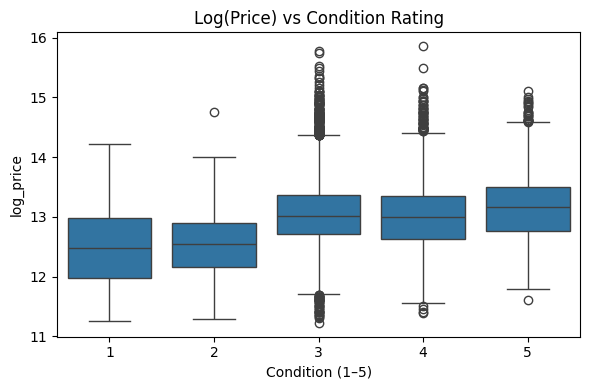

In [311]:
#last tier - weak and negative correlation features
# 1) Zipcode vs log_price
plt.figure(figsize=(10,4))
sns.boxplot(data=housing_data, x="zipcode", y="log_price")
plt.title("Log(Price) vs Zipcode")
plt.xlabel("Zipcode")
plt.ylabel("log_price")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 2) Year Built vs log_price 
plt.figure(figsize=(6,4))
sns.regplot(
    data=housing_data,
    x="yr_built",
    y="log_price",
    scatter_kws={"alpha":0.3}
)
plt.title("Log(Price) vs Year Built")
plt.xlabel("Year Built")
plt.ylabel("log_price")
plt.tight_layout()
plt.show()

# 3) Condition vs log_price 
plt.figure(figsize=(6,4))
sns.boxplot(data=housing_data, x="condition", y="log_price")
plt.title("Log(Price) vs Condition Rating")
plt.xlabel("Condition (1–5)")
plt.ylabel("log_price")
plt.tight_layout()
plt.show()

# notes:
# zipcodes : they show no linear trend with proce since there is no spatial meaning. some zipcodes have higher medians, but no linear pattern.
# yr_built : newer homes are slightly more expensive but the relationship is weak and largely uniform across years. 
# condition : condition has only a mild positive effect because prices falls in the same middle condition categories. 

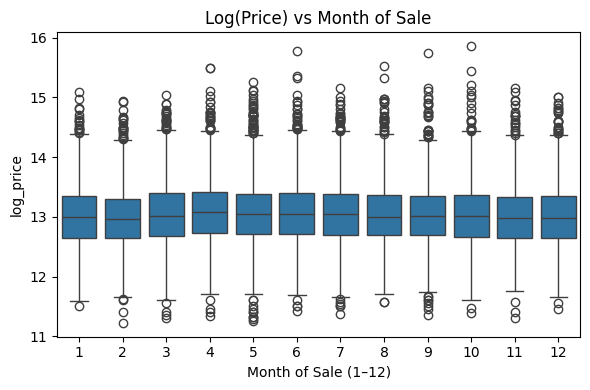

In [312]:
plt.figure(figsize=(6,4))
sns.boxplot(data=housing_data, x="sale_month", y="log_price")
plt.title("Log(Price) vs Month of Sale")
plt.xlabel("Month of Sale (1–12)")
plt.ylabel("log_price")
plt.tight_layout()
plt.show()

In [313]:
# ---- Feature Engineering: 
# STEP 1 : Creating Derived Variables ----

# Renovation indicator (1 = has renovation year)
housing_data["is_renovated"] = (housing_data["yr_renovated"] > 0).astype(int)

# 1) Compute house age
housing_data["house_age"] = housing_data["sale_year"] - housing_data["yr_built"]
housing_data.loc[housing_data["house_age"] < 0, "house_age"] = 0

# 2) Optional binned age groups
housing_data["house_age_bin"] = pd.cut(
    housing_data["house_age"],
    bins=[0, 20, 50, 100, housing_data["house_age"].max()],
    labels=["<20 yrs", "20–50 yrs", "50–100 yrs", ">100 yrs"]
)

# Remove price_per_sqft, it leaks the target because it’s directly computed from price.
# 3) Price per square foot
#housing_data["price_per_sqft"] = housing_data["price"] / housing_data["sqft_living"]


# 3b) Area ratios (model-friendly features)
housing_data["basement_ratio"] = housing_data["sqft_basement"] / housing_data["sqft_living"]
housing_data["above_ratio"] = housing_data["sqft_above"] / housing_data["sqft_living"]
housing_data["lot_living_ratio"] = housing_data["sqft_lot"] / housing_data["sqft_living"]

#  division by zero safeguard
housing_data["basement_ratio"] = housing_data["sqft_basement"] / housing_data["sqft_living"].replace(0, np.nan)

# 4) Rename to average neighborhood avg_sqft
housing_data.rename(
    columns={"sqft_living15": "neighborhood_avg_sqft"},
    inplace=True
)

print("\nPreview of engineered columns:")
print(
    housing_data[
        [
         "yr_built", "sale_year", "house_age", "house_age_bin",
         "is_renovated",
         "neighborhood_avg_sqft", "yr_since_renovated",
         "basement_ratio", "above_ratio", "lot_living_ratio"
        ]
    ].head()
)

housing_data.to_csv("../data/kc_house_data_engineered.csv", index=False)
print("\n✓ Feature-engineered dataset saved.")



Preview of engineered columns:
   yr_built  sale_year  house_age house_age_bin  is_renovated  \
0      1955       2014         59    50–100 yrs             0   
1      1951       2014         63    50–100 yrs             1   
2      1933       2015         82    50–100 yrs             0   
3      1965       2014         49     20–50 yrs             0   
4      1987       2015         28     20–50 yrs             0   

   neighborhood_avg_sqft  yr_since_renovated  basement_ratio  above_ratio  \
0                   1340                 NaN        0.000000     1.000000   
1                   1690                23.0        0.155642     0.844358   
2                   2720                 NaN        0.000000     1.000000   
3                   1360                 NaN        0.464286     0.535714   
4                   1800                 NaN        0.000000     1.000000   

   lot_living_ratio  
0          4.788136  
1          2.817899  
2         12.987013  
3          2.551020  
4   

In [314]:
# ---- Feature Engineering 
# Step 2: Drop Irrelevant or Redundant Columns ----

# Columns identified during EDA as unnecessary for modeling
columns_to_remove = [
    "id",             # Unique id with no predictive value
    "date",           # replaced by parsed year/month fields
    "yr_renovated",   # Sparse, replaced by 'is_renovated'
    "sale_month",     
    "price"           
    # "sqft_lot15"    
]

# Drop only the columns that actually exist (prevents KeyError)
housing_data.drop(
    columns=[col for col in columns_to_remove if col in housing_data.columns],
    inplace=True
)

# Check the updated set of features
print("Columns remaining after cleanup:")
print(housing_data.columns.tolist())

# Save the cleaned version (feature-engineered, step 2)
housing_data.to_csv("../data/kc_house_data_engineered_step2.csv", index=False)
print("Feature-engineered dataset (Step 2) saved.")



Columns remaining after cleanup:
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'neighborhood_avg_sqft', 'sqft_lot15', 'sale_year', 'yr_since_renovated', 'log_price', 'is_renovated', 'house_age', 'house_age_bin', 'basement_ratio', 'above_ratio', 'lot_living_ratio']
Feature-engineered dataset (Step 2) saved.


In [315]:
# ---- Feature Engineering Step 3A: One-Hot Encoding for Linear Regression ----

import pandas as pd

# Load the feature-engineered dataset from Step 2
linear_base = pd.read_csv("../data/kc_house_data_engineered_step2.csv")

# Convert ordinal categories to integer type for consistency
ordinal_features = ["grade", "condition", "view"]
linear_base[ordinal_features] = linear_base[ordinal_features].astype(int)

# Make a working copy for linear-model preprocessing
linear_data = linear_base.copy()

# One-Hot encode zipcode to avoid imposing false numeric order
linear_data = pd.get_dummies(
    linear_data,
    columns=["zipcode"],
    prefix="zip",
    drop_first=True     # drop first column to prevent multicollinearity
)

# One-Hot encode the age category bins (if available)
if "house_age_bin" in linear_data.columns:
    linear_data = pd.get_dummies(
        linear_data,
        columns=["house_age_bin"],
        prefix="agebin",
        drop_first=True
    )

# Quick checks on dataset structure
print("Linear dataset shape:", linear_data.shape)
print("Columns still stored as object type:", 
      linear_data.select_dtypes(include=['object']).columns.tolist())

# Save the encoded dataset
linear_data.to_csv("../data/kc_house_data_encoded_linear_step3.csv", index=False)
print("Linear-model dataset saved (Step 3A).")


Linear dataset shape: (21613, 96)
Columns still stored as object type: []
Linear-model dataset saved (Step 3A).


In [316]:
# ---- Feature Engineering Step 3B: Encoding for Tree-Based Models ----

from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load the dataset from Step 2
tree_base = pd.read_csv("../data/kc_house_data_engineered_step2.csv")

# Convert ordinal variables to integer for consistency
ordinal_features = ["grade", "condition", "view"]
tree_base[ordinal_features] = tree_base[ordinal_features].astype(int)

# Work on a copy for tree model preprocessing
housing_data_tree = tree_base.copy()

# Label-encode zipcode (treat as string to avoid numeric ordering issues)
le = LabelEncoder()
housing_data_tree["zipcode"] = le.fit_transform(
    housing_data_tree["zipcode"].astype(str)
)

# Encode age bins as ordered integers if present
if "house_age_bin" in housing_data_tree.columns:
    age_mapping = {"<20 yrs": 1, "20–50 yrs": 2, "50–100 yrs": 3, ">100 yrs": 4}
    housing_data_tree["house_age_bin"] = (
        housing_data_tree["house_age_bin"].map(age_mapping).astype("Int64")
    )

print("Tree-based dataset shape:", housing_data_tree.shape)
print(
    "Remaining object columns:",
    housing_data_tree.select_dtypes(include=["object"]).columns.tolist()
)

# Save the tree-ready dataset
housing_data_tree.to_csv("../data/kc_house_data_encoded_tree_step3.csv", index=False)
print("Tree-model dataset saved (Step 3B).")

Tree-based dataset shape: (21613, 26)
Remaining object columns: []
Tree-model dataset saved (Step 3B).


In [317]:
print(df_linear.select_dtypes(include=["object"]).columns)  # Should return []
print(df_tree.select_dtypes(include=["object"]).columns)    # Should return []


NameError: name 'df_linear' is not defined